In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
dataset = "flickr30k"


paths = {"flickr30k": "/raid/datasets/f30k",
         "mscoco": "/raid/datasets/coco"}
path = paths[dataset]

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string
nltk.download('stopwords')
nltk.download('punkt')

def filter_words(sent):
    stop_words = set(stopwords.words('english'))
    #stop_words.remove("of")
    for w in ["other", "scene", "notvisual", "one", "something", "foreground", "background", 
              "people", "many", "several", "bunch", "lot", "left", "right", "top", "bottom", "others", "another"]:
        stop_words.add(w)
    word_tokens = word_tokenize(sent)
    filtered_sentence = [w.lower().translate(string.punctuation) for w in word_tokens]
    filtered_sentence = [w for w in filtered_sentence if w not in stop_words and w.isalpha()]
    return " ".join(filtered_sentence)

[nltk_data] Downloading package stopwords to
[nltk_data]     /srv/home/8wiehe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /srv/home/8wiehe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def get_valid_key_names(inv_dict, k=10, verbose=False, filter_words=None):
    sorted_keys = sorted(inv_dict, key=lambda x: len(set([l // 5 for l in inv_dict[x]])), reverse=True)
    valid_label_names = []
    count = 0
    for key in sorted_keys:
        if filter_words is not None:
            if key in filter_words:
                continue
        if verbose:
            print(key)
            print(len(inv_dict[key]))
        if len(key) > 2:
            valid_label_names.append(key)
        count += 1
        if count == k:
            break
    return valid_label_names

In [5]:
def get_labels(sent_data):
    labels = [[phrase["phrase"] for phrase in sent_dict["phrases"]] for sent_dict in sent_data]
    labels += [[phrase["phrase_type"] for phrase in sent_dict["phrases"]] for sent_dict in sent_data]
    flat_labels = set()
    for label in labels:
        if isinstance(label, list):
            for l in label:
                if isinstance(l, list):
                    for lab in l:
                        flat_labels.add(lab)
                else:
                    flat_labels.add(l)
        else:
            flat_labels.add(label)
    flat_labels = list(flat_labels)
    labels = sorted([element for element in set([filter_words(sent) for sent in flat_labels]) if len(element) > 2])
    return labels

In [6]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


# load img paths
def is_img(img_name):
    return img_name.endswith(".jpg") or img_name.endswith(".jpeg") or img_name.endswith(".png")


def load_flickr(path, num_imgs=None):
    img_folder = os.path.join(path, "images")
    imgs = [i for i in os.listdir(img_folder) if is_img(i)]
    imgs = sorted(imgs, key = lambda x: int(x.split(".")[0]))
    img_ids = [int(x.split(".")[0]) for x in imgs]
    img_paths = [os.path.join(img_folder, i) for i in imgs]

    # load captions
    captions = pd.read_csv(os.path.join(path, "captions.txt"), delimiter="|")
    captions["img_idx"] = captions["image_name"].apply(lambda x: int(x.split(".")[0]))
    captions = captions.sort_values("img_idx")
    del captions["img_idx"]
    
    if num_imgs is not None:
        imgs = imgs[:num_imgs]
        img_paths = imgs[:num_imgs]
        img_ids = img_ids[:num_imgs]
        captions = captions[:num_imgs * 5]
    
    # annotated bounding box labels:
    # from https://github.com/BryanPlummer/flickr30k_entities
    import sys
    sys.path.append("/raid/datasets")
    from flickr30k_entities.flickr30k_entities_utils import get_annotations, get_sentence_data
    from collections import defaultdict

    labels = []
    label_count = defaultdict(int)

    # load relations between img bounding boxes and captions
    for img_id in tqdm(img_ids):
        #p = f"/raid/datasets/flickr30k_entities/Annotations/{img_id}.xml"
        #annot = get_annotations(p)
        p = f"/raid/datasets/flickr30k_entities/Sentences/{img_id}.txt"
        sent_data = get_sentence_data(p)
        img_labels = get_labels(sent_data)
        # increase counts
        for l in img_labels:
            label_count[l] += 1
        # store
        labels.append(img_labels)

    # get label names with highest count
    label_series = pd.Series(label_count.values(), index=label_count.keys()).sort_values(ascending=False).iloc[:500]
    label_names = list(label_series.index)
    # sort through all labels to only keep high count labels
    labels = [[l for l in label_list if l in label_names] for label_list in labels]

    figsize = (6, 50)
    plt.figure(figsize=figsize)
    sns.barplot(y=label_series.index, x=label_series)
    plt.savefig("flickr30k/label_counts.png")
    plt.title("Label frequency Flickr30k")
    plt.show()


    # get training splits
    test_ids = pd.read_csv("/raid/datasets/flickr30k_entities/test.txt", sep="\n", header=None)
    train_ids = pd.read_csv("/raid/datasets/flickr30k_entities/train.txt", sep="\n", header=None)
    val_ids = pd.read_csv("/raid/datasets/flickr30k_entities/val.txt", sep="\n", header=None)
    print("Num train samples: ", len(train_ids))
    print("Num val samples: ", len(val_ids))
    print("Num test samples: ", len(test_ids))
    
    #return img_paths, captions, labels, specific_inv_dict, broad_inv_dict, specific_dict, broad_dict, all_label_names
    return img_paths, img_ids, captions, labels, train_ids, val_ids, test_ids, label_names


def load_coco(path):
    img_folder = os.path.join(path, "images")
    imgs = [i for i in os.listdir(img_folder) if is_img(i)]
    imgs = sorted(imgs, key = lambda x: int(x.split(".")[0].split("_")[1]))
    img_ids = [int(x.split(".")[0]) for x in imgs]
    img_paths = [os.path.join(img_folder, i) for i in imgs]

    # load captions
    train_caps = json.load(open("annotations/captions_train2014.json", "r"))
    file_name = train_caps["images"][0]["file_name"]
    id_ = train_caps["images"][0]["id"]
    
    # load captions
    captions = pd.read_csv(os.path.join(path, "captions.txt"), delimiter="|")
    captions["img_idx"] = captions["image_name"].apply(lambda x: int(x.split(".")[0]))
    captions = captions.sort_values("img_idx")
    del captions["img_idx"]
    return img_paths, captions


    return img_paths, img_ids, captions, label_strs, train_ids, val_ids, test_ids, label_names

In [7]:
# define dataset specifics
if dataset == "flickr30k":
    label_path = "flickr30k/labels.npy"
    load_func = load_flickr
elif dataset == "coco":
    label_path = "coco/labels.npy"
    load_func = load_coco

# load or create
if not os.path.exists(label_path):
    out = load_func(path)
    np.save(label_path, out)
else:
    out = np.load(label_path, allow_pickle=True)
img_paths, img_ids, captions, label_strs, train_ids, val_ids, test_ids, label_names = out
    
# check correctness of lens
assert len(img_paths) == len(img_ids)
assert len(img_paths) == len(train_ids) + len(val_ids) + len(test_ids)
assert len(captions) % len(img_ids) == 0
assert len(img_ids) == len(label_strs)

In [8]:
#help(sns.boxplot)

Num images without label:  32
Median:  7.0


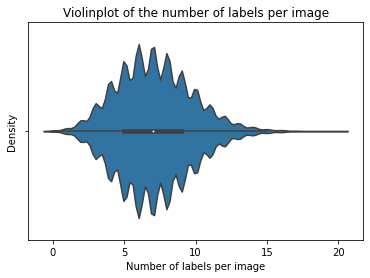

In [9]:
labels_per_img = np.array([len(labels) for labels in label_strs])
#sns.boxplot(x=labels_per_img)
sns.violinplot(x=labels_per_img)

p = plt.title("Violinplot of the number of labels per image")
plt.xlabel("Number of labels per image")
plt.ylabel("Density")
print("Num images without label: ", len(labels_per_img[labels_per_img == 0]))
print("Median: ", np.median(labels_per_img))

plt.savefig(os.path.join(dataset, f"labels_per_img.pdf"), dpi=300)

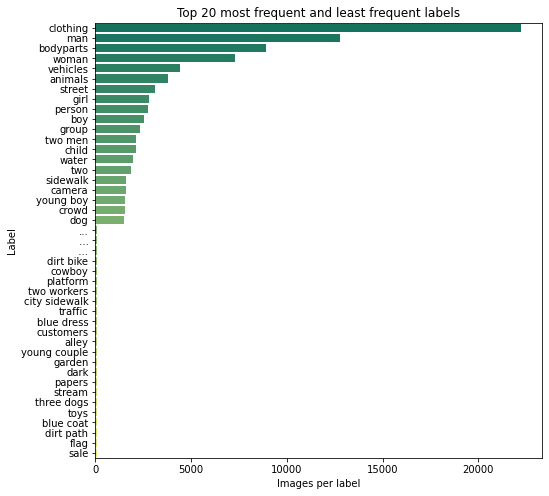

In [10]:
from collections import defaultdict

imgs_per_label = defaultdict(int)
for img_labels in label_strs:
    for l in set(img_labels):
        imgs_per_label[l] += 1
imgs_per_label_df = pd.Series(list(imgs_per_label.values()), index=list(imgs_per_label.keys()))
imgs_per_label_df = imgs_per_label_df.sort_values(ascending=False)

show_df = pd.concat([imgs_per_label_df.iloc[:20], pd.Series([102, 101, 100], index=["...", " ...", "  ..."]), imgs_per_label_df.iloc[-20:]], axis=0)
#show_df = np.ln(show_df)
plt.figure(figsize=(8, 8))
sns.barplot(x=show_df, y= show_df.index, palette="summer")
plt.title("Top 20 most frequent and least frequent labels")
plt.xlabel("Images per label")
plt.ylabel("Label")
plt.savefig(os.path.join(dataset, f"imgs_per_label.pdf"), dpi=300)
plt.show()

In [11]:
captions_per_img = len(captions) // len(img_paths)
captions_per_img

5

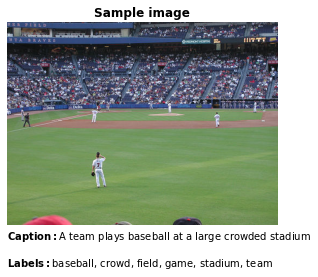

In [12]:
# show qualitative data
idx = 3
caption_idx = idx * captions_per_img

img = Image.open(img_paths[idx])
fig = plt.figure()
p = plt.imshow(img)
plt.axis("off")
plt.title("Sample image", fontweight="bold")
plt.text(0, 400, r"$\bf{Caption: }$" + captions["caption_text"].iloc[caption_idx].strip(".").strip())
plt.text(0, 450, r"$\bf{Labels: }$" + ", ".join(label_strs[idx]))
plt.tight_layout()
plt.savefig(os.path.join(dataset, f"sample_{idx}.pdf"), dpi=300)

In [13]:
def get_data(img_idx, return_img=False):
    img_name = img_ids[img_idx]
    img_captions = [captions.iloc[img_idx * 5 + i]["caption_text"] for i in range(5)]
    img = Image.open(img_paths[img_idx]) if return_img else img_paths[img_idx]
    return img_name, img_captions, img

test = False
if test:
    img_idx = 666

    img_name, img_captions, img = get_data(img_idx, return_img=True)
    print(img_name)
    print(img_captions)
    img.show()

In [14]:
import clip
import torch
print(clip.available_models())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_name = "RN50"
model, transform = clip.load(clip_name, jit=False, device=device)
load_path = None

/srv/home/8wiehe/.local/lib/python3.8/site-packages/clip/clip.py:23: UserWarning: PyTorch version 1.7.1 or higher is recommended
  warnings.warn("PyTorch version 1.7.1 or higher is recommended")


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']


In [15]:
from utils import get_image_features, get_text_features

test_sims = False
idx = 5002
personal_caption = ""

if test_sims:
    img_name, img_captions, img = get_data(idx)
    if len(personal_caption) > 0:
        img_captions.append(personal_caption)


    img_features = get_image_features([img], model, transform, device, 
                                      load_path, batch_size=16, save=False)
    caption_features = get_text_features(img_captions, model, device, 
                                         load_path, batch_size=16, save=False)

    sims = torch.cosine_similarity(img_features, caption_features)
    top_k = sims.topk(k=5)
    indices = top_k.indices
    vals = top_k.values

    Image.open(img).show()
    for idx, val in zip(indices, vals):
        print(val, img_captions[idx])

In [16]:
load_path = os.path.join(dataset, "feats")
clip_load_name = clip_name.replace("/", "_")
clip_load_name

'RN50'

In [ ]:
os.makedirs(load_path, exist_ok=True)
bs = 32

img_features = get_image_features(img_paths, model, transform, device, 
                                  os.path.join(load_path, f"{clip_load_name}_img_feats.pt"), 
                                  batch_size=bs, save=True)
caption_features = get_text_features(captions["caption_text"], model, device, 
                                     os.path.join(load_path, f"{clip_load_name}_caption_feats.pt"), 
                                     batch_size=bs, save=True)

  0%|          | 0/994 [00:00<?, ?it/s]

  0%|          | 0/4967 [00:00<?, ?it/s]

In [ ]:
from captum.attr import IntegratedGradients, NoiseTunnel, Saliency
import torchvision

to_pil = torchvision.transforms.ToPILImage()

def minmax(a):
    min_ = a.min()
    max_ = a.max()
    return (a - min_) / (max_ - min_)


class MeanModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        return self.model.encode_image(x).mean(dim=1).unsqueeze(-1)

    
class CosineModel(torch.nn.Module):
    def __init__(self, model, tokenized_text):
        super().__init__()
        self.model = model
        self.text_feats = model.encode_text(tokenized_text)
    
    def forward(self, img):
        #img, tokenized_text = inputs
        img_feats = self.model.encode_image(img)
        #print(img_feats.squeeze().shape)
        #return img_feats.squeeze()
        return torch.cosine_similarity(img_feats, self.text_feats).unsqueeze(-1)


def get_saliency(model, img_path, transform):
    # wrap model to get mean feature
    model = MeanModelWrapper(model).cpu().float()
    # load img
    img = transform(Image.open(img_path)).unsqueeze(0).cpu().float()
    img.requires_grad = True
    # get attribution
    ig = IntegratedGradients(model)
    #ig = Saliency(model)
    nt = NoiseTunnel(ig)
    attribution = nt.attribute(img, nt_type='smoothgrad',
                               nt_samples=10, target=0)
    return attribution


def get_saliency_cosine(model, img_path, text, transform, std=0.5, 
                        nt_samples=100, use_ig=False, nt_type="smoothgrad",
                        abs=False, pos=False, t=5, perc=1):
    device = torch.device("cuda")
    dtype = torch.float
    # tokenize text
    tokenized = clip.tokenize(text, truncate=True).to(device)
    # wrap model to get cosine sim of text and img. feed text in here to avoid casting to float when passing it in  nt.attribute
    model.to(device).to(dtype)
    model = CosineModel(model, tokenized)
    # load img
    img = transform(Image.open(img_path)).unsqueeze(0).to(device).to(dtype)
    img.requires_grad = True
    # get attribution
    if use_ig:
        ig = IntegratedGradients(model, multiply_by_inputs=True)
        kwargs = {"internal_batch_size": 8, "n_steps": 50}
    else:
        ig = Saliency(model)
        kwargs = {"abs": abs}
    nt = NoiseTunnel(ig)
    attribution = nt.attribute(img, nt_type=nt_type, nt_samples=nt_samples, 
                               target=0, stdevs=std, nt_samples_batch_size=4,
                               **kwargs)
    #attribution = attribution.squeeze().mean(dim=0)
    # normed attribution
    attribution = attribution.squeeze().mean(dim=0) # take mean over rgb dimension
    
    p = plt.hist(attribution.cpu().flatten().numpy(), bins=1000)
    plt.show()
    
    if pos:
        print("Min val: ", min(attribution[attribution > 0]))
        attribution[attribution < 0] = min(attribution[attribution > 0])
    
    attribution = minmax(attribution)
    #attribution = torch.softmax(attribution.flatten() * t, dim=0).reshape(*attribution.shape)
    
    quant = torch.quantile(attribution, 1 - perc / 100)
    attribution[attribution > quant] = quant
    quant = torch.quantile(attribution, perc / 100)
    attribution[attribution < quant] = quant

    
    attribution = minmax(attribution)
    
    if not abs and not pos:
        attribution = attribution * 2 - 1
    return attribution            

In [ ]:
def get_grad(img_path, text, std=0.0):
    img = transform(Image.open(img_path)).unsqueeze(0).to(device).to(torch.float)
    if std != 0:
        img = img + torch.normal(0.0, std, list(img.shape), device=img.device)
    img.requires_grad = True
    img_feats = model.encode_image(img)

    tokenized_text = clip.tokenize(text, truncate=True).to(device)
    text_feats = model.encode_text(tokenized_text)

    sim = torch.cosine_similarity(img_feats, text_feats).unsqueeze(-1)
    sim.backward()

    grad = img.grad
    return grad

def sg(img_path, text, std=1.0, nt=10, pos=False, absolute=False):
    grads = torch.stack([get_grad(img_path, text, std=std) for _ in range(nt)])
    if pos:
        grads[grads < 0] = 0
    if absolute:
        grads = torch.abs(grads)
    return torch.mean(grads, dim=0)
    
    

#grad = get_grad(img_path, text, std=1.0)
#mean_grad = sg(img_path, text, std=1.0, nt=10, pos=False, absolute=True)
#p = plt.hist(mean_grad.cpu().flatten().numpy(), bins=1000)

In [ ]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

In [ ]:
idx = 0

std = 1.0
nt_samples = 30
abs = True
pos = False
t = 1

#img_path = img_paths[idx]
img_path = "ipod_note_apple.png"
#caption = captions["caption_text"].iloc[idx * 5]
caption = "wait a second, this is just an apple with a label saying ipod"
#caption = "a backyard"
#caption = "a tube"

loaded_img = torchvision.transforms.Compose(transform.transforms[:-1])(Image.open(img_path)).squeeze()
print("Caption:", caption)
#Image.open(img_path).show()
to_pil(loaded_img).show()

import cv2
def show_cam_on_image(img, mask):
    mask = (mask * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

print("Custom SG:")
sal = sg(img_path, caption, std=std, nt=nt_samples, pos=pos, absolute=abs)
sal = sal.squeeze().mean(dim=0)
sal = (sal - sal.min()) / (sal.max() - sal.min())
p = plt.hist(sal.cpu().flatten().numpy(), bins=1000)
plt.show()
cmap = None if abs or pos else "coolwarm"
sns.heatmap(sal.squeeze().cpu().numpy(), cmap=cmap)
plt.axis("off")
plt.show()
#cosine_sal = torch.abs(cosine_sal)
to_pil(sal.squeeze()).show()
to_pil(sal.squeeze() * loaded_img.squeeze().cuda()).show()
# heatmap mask
image = np.moveaxis(np.array(loaded_img), 0, -1)
image_relevance = sal.cpu().unsqueeze(-1).float().numpy()
vis = show_cam_on_image(image, image_relevance)
vis = np.uint8(255 * vis)
vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
plt.imshow(vis)
plt.show()

print("Smoothgrad")
cosine_sal = get_saliency_cosine(model, img_path, caption, transform, std=std, nt_samples=nt_samples, abs=abs, t=t, pos=pos)
p = plt.hist(cosine_sal.cpu().flatten().numpy(), bins=1000)
plt.show()
cmap = None if abs or pos else "coolwarm"
sns.heatmap(cosine_sal.squeeze().cpu().numpy(), cmap=cmap)
plt.axis("off")
plt.show()
cosine_sal[cosine_sal < 0.5] = 0
cosine_sal = torch.abs(cosine_sal)
to_pil(cosine_sal.squeeze()).show()
to_pil(cosine_sal.squeeze() * loaded_img.squeeze().cuda()).show()

# create heatmap from mask on image
image = np.moveaxis(np.array(loaded_img), 0, -1)
image_relevance = cosine_sal.cpu().unsqueeze(-1).float().numpy()
vis = show_cam_on_image(image, image_relevance)
vis = np.uint8(255 * vis)
vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

plt.imshow(vis)
plt.show()


vargrad = True
if vargrad:
    print("VarGrad")
    cosine_sal = get_saliency_cosine(model, img_path, caption, transform, std=std, nt_samples=nt_samples, nt_type="vargrad", t=t, abs=abs)
    p = plt.hist(minmax(cosine_sal).cpu().flatten().numpy(), bins=1000)
    plt.show()
    to_pil(minmax(cosine_sal).squeeze()).show()
    to_pil(minmax(cosine_sal).squeeze() * loaded_img.squeeze().cuda()).show()
ig = False
if ig:
    print("IG")
    cosine_sal = get_saliency_cosine(model, img_path, caption, transform, std=std, nt_samples=nt_samples // 5, use_ig=True)
    cosine_sal = minmax(torch.abs(cosine_sal - 0.5))
    p = plt.hist((cosine_sal).cpu().flatten().numpy(), bins=1000)
    plt.show()
    to_pil((cosine_sal).squeeze()).show()
    to_pil((cosine_sal).squeeze() * loaded_img.squeeze().cuda()).show()

In [ ]:
# img2text
img_idx = 20000

sims = torch.cosine_similarity(img_features[img_idx].unsqueeze(0), caption_features)
Image.open(img_paths[img_idx]).show()
idx = sims.topk(k=1).indices[0].item()
print(idx)
get_data(idx // 5, return_img=True)[2].show()
print(captions["caption_text"].iloc[idx], "\n")
print("Real captions:")
for text in get_data(img_idx)[1]:
    print(text)

In [ ]:
# text2img
text_idx = 5004

print(captions["caption_text"].iloc[text_idx])
sims = torch.cosine_similarity(caption_features[text_idx].unsqueeze(0), img_features)
idx = sims.topk(k=1).indices[0].item()
print(idx)
print("Found:")
Image.open(img_paths[idx]).show()
print("Ground truth: ")
Image.open(img_paths[text_idx // 5]).show()

In [ ]:
from tqdm.auto import tqdm
from typing import List
import numpy as np


def calc_metrics(feats, caption_features):
    sims = torch.cosine_similarity(feats, caption_features)
    #pred_idcs: List[int] = sims.topk(k=10).indices.tolist()
    pred_idcs = sims.topk(k=10).indices
    return pred_idcs


def calc_img2text_retrieval(img_features, caption_features, cap_per_img=5):
    #calc_metrics = torch.jit.trace(calc_metrics, (img_features[0].unsqueeze(0), caption_features))
    r1 = torch.zeros(img_features.shape[0])
    r5 = torch.zeros(img_features.shape[0])
    r10 = torch.zeros(img_features.shape[0])
    for img_idx in tqdm(torch.arange(img_features.shape[0], device=img_features.device)):
        feats = img_features[img_idx].unsqueeze(0)
        #print(feats.device, caption_features.device, img_idx.device)
        pred_idcs = calc_metrics(feats, caption_features)
        ground_truth_idcs = torch.arange(cap_per_img, device=feats.device) + img_idx * cap_per_img
        r1_val = any([pred_idcs[i] in ground_truth_idcs for i in range(1)])
        r5_val = any([pred_idcs[i] in ground_truth_idcs for i in range(5)])
        r10_val = any([pred_idcs[i] in ground_truth_idcs for i in range(10)])
        r1[img_idx] = r1_val
        r5[img_idx] = r5_val
        r10[img_idx] = r10_val
    return r1, r5, r10


def calc_text2img_retrieval(caption_features, img_features, cap_per_img=5):
    r1 = torch.zeros(caption_features.shape[0])
    r5 = torch.zeros(caption_features.shape[0])
    r10 = torch.zeros(caption_features.shape[0])
    for cap_idx in tqdm(torch.arange(caption_features.shape[0], device=caption_features.device)):
        feats = caption_features[cap_idx].unsqueeze(0)
        #print(feats.device, caption_features.device, img_idx.device)
        pred_idcs = calc_metrics(feats, img_features)
        ground_truth_idx = cap_idx // cap_per_img
        r1_val = (pred_idcs[:1] == ground_truth_idx).max()
        r5_val = (pred_idcs[:5] == ground_truth_idx).max()
        r10_val = (pred_idcs[:10] == ground_truth_idx).max()
        r1[cap_idx] = r1_val
        r5[cap_idx] = r5_val
        r10[cap_idx] = r10_val
    return r1, r5, r10

In [ ]:
calc_retrieval_metrics = True

In [ ]:
import time

if calc_retrieval_metrics:
    query_feats = img_features.cuda()
    target_feats = caption_features.cuda()

    now = time.time()
    metrics = calc_img2text_retrieval(query_feats, target_feats)
    print(time.time() - now)
    for i in range(len(metrics)):
        print(torch.mean(metrics[i]))

In [ ]:
if calc_retrieval_metrics:

    query_feats = caption_features[:].cuda()
    target_feats = img_features.cuda()

    now = time.time()
    text2img_metrics = calc_text2img_retrieval(query_feats, target_feats)
    print(time.time() - now)
    for i in range(len(text2img_metrics)):
        print(torch.mean(text2img_metrics[i]))

In [ ]:
def add_prompt(labels, prefix="", suffix=""):
    new_labels = [prefix + l + suffix for l in labels]
    return new_labels

# zero shot prediction
use_multi_label_setting = False

def norm(a):
    return a / a.norm(dim=-1, keepdim=True)


def create_label_encs(prefixes, use_multi_label_setting=False, use_norm=False):
    if use_multi_label_setting:
        # create queries
        label_queries = [add_prompt(label_names, prefix=prefix) for prefix in prefixes]
        # encode queries
        label_encs = [get_text_features(label_query, model, device, 
                                             None,#os.path.join(load_path, f"{clip_name}_caption_feats.pt"), 
                                             batch_size=bs, save=False) for label_query in label_queries]
        label_encs = torch.stack(label_encs).mean(dim=0)
        print(label_encs.shape)
    else:
        # create baseline query, then positive query and construct negative encoding by 
        # subtracting pos encoding minus baseline encoding
        all_diff_encs = []
        for prefix in prefixes:
            baseline_enc = get_text_features([prefix], model, device, None, batch_size=1, save=False)[0]
            pos_encs = get_text_features(add_prompt(label_names, prefix=prefix), model, device, None, batch_size=32, save=False)
            if use_norm:
                diff_encs = pos_encs - baseline_enc#norm(norm(pos_encs) - norm(baseline_enc))
            else:
                diff_encs = pos_encs - baseline_enc
            all_diff_encs.append(diff_encs)
        diff_enc = norm(torch.stack(all_diff_encs)).mean(dim=0)
        if use_norm:
            neg_encs = norm(baseline_enc - diff_enc)#norm(norm(baseline_enc) - norm(diff_enc))
        else:
            neg_encs = baseline_enc - diff_enc

        #label_encs = torch.stack(neg_encs)
        label_encs = [pos_encs, neg_encs]
    return label_encs

In [ ]:
def label_strs_to_int(label_strs, label_names):
    return torch.tensor([l in label_strs for l in label_names]).long()

In [ ]:
def calc_accuracies(img_features, label_encs):
    r1_sum = 0
    r5_sum = 0
    r10_sum = 0

    for img_idx in tqdm(range(len(img_paths))):
        img_enc = img_features[img_idx].unsqueeze(0)    
        sims = torch.cosine_similarity(img_enc, label_encs)
        pred_idcs = sims.topk(k=10).indices
        top_idx = pred_idcs[0]
        gt_labels = label_strs[img_idx]
        gt_label_idcs = torch.where(label_strs_to_int(gt_labels, label_names))[0]
        
        r1 = 0
        r5 = 0
        r10 = 0
        for i, pred in enumerate(pred_idcs):
            if pred in gt_label_idcs:
                if i == 0:
                    r1, r5, r10 = 1, 1, 1
                elif i < 5:
                    r5, r10 = 1, 1
                else:
                    r10 = 1
                break
        r1_sum += r1
        r5_sum += r5
        r10_sum += r10
    return (r1_sum / (img_idx + 1), r5_sum / (img_idx + 1), r10_sum / (img_idx + 1))

In [ ]:
def calc_binary_acc(img_features, pos_label_encs, neg_label_encs):
    # make list if not list yet
    if not isinstance(pos_label_encs, list):
        pos_label_encs = [pos_label_encs]
        neg_label_encs = [neg_label_encs]
    
    accs = []
    for img_idx in tqdm(range(len(img_paths))):
        gt_labels = label_strs[img_idx]
        gt_label_idcs = torch.where(label_strs_to_int(gt_labels, label_names))[0]
        gt_binary = torch.zeros(len(label_names)).bool()
        gt_binary[gt_label_idcs] = True
        
        img_enc = img_features[img_idx].unsqueeze(0)    
        
        img_pos_sims = []
        img_neg_sims = []
        for pos_encs, neg_encs in zip(pos_label_encs, neg_label_encs):
            pos_sims = torch.cosine_similarity(img_enc, pos_encs)
            neg_sims = torch.cosine_similarity(img_enc, neg_encs)
            img_pos_sims.append(pos_sims)
            img_neg_sims.append(neg_sims)
            
            
        pos_sims = torch.stack(img_pos_sims).mean(dim=0)
        neg_sims = torch.stack(img_neg_sims).mean(dim=0)

        binary_preds = pos_sims > neg_sims
        #binary_preds = torch.zeros(len(label_names))
        preds = torch.where(binary_preds)[0]
        acc = (binary_preds == gt_binary).float().mean()
        #img_accs.append(acc)
        #acc = torch.mean(torch.stack(img_accs))
        #print(gt_label_idcs)
        #print(len(preds))
        #print(acc)
        #print()
        accs.append(acc)

    return accs

In [ ]:
prefixes = ["A picture of "]
#prefixes = [ "stock image "]
accs = calc_binary_acc(img_features, 
                       *create_label_encs(prefixes, use_multi_label_setting=False, use_norm=False))
torch.mean(torch.stack(accs)).item()

In [ ]:
prefixes = ["A photo of "]
#prefixes = [ "stock image "]
accs = calc_binary_acc(img_features, 
                       *create_label_encs(prefixes, use_multi_label_setting=False, use_norm=False))
torch.mean(torch.stack(accs)).item()

In [ ]:
prefixes = ["A photo of a people. "]
#prefixes = [ "stock image "]
accs = calc_binary_acc(img_features, 
                       *create_label_encs(prefixes, use_multi_label_setting=False, use_norm=True))
torch.mean(torch.stack(accs)).item()

In [ ]:
prefixes = ["A photo of ", "A ", "A picture of ", "picture ", "A picture of a person. ", "flickr. ", "stock image. "]

pos_encs = []
neg_encs = []

for prefix in prefixes:
    pos_enc, neg_enc = create_label_encs([prefix], use_multi_label_setting=False, use_norm=False)
    pos_encs.append(pos_enc)
    neg_encs.append(neg_enc)

accs = calc_binary_acc(img_features, pos_encs, neg_encs)
torch.mean(torch.stack(accs)).item()

In [ ]:
import string    
import random # define the random module  
S = 10  # number of characters in the string.  
# call random.choices() string module to find the string in Uppercase + numeric data.  


In [ ]:
prefixes = [''.join(random.choices(string.ascii_uppercase + string.digits, k = S)) + ". " for _ in range(1000)]

pos_encs = []
neg_encs = []

for prefix in prefixes:
    pos_enc, neg_enc = create_label_encs([prefix], use_multi_label_setting=False, use_norm=False)
    pos_encs.append(pos_enc)
    neg_encs.append(neg_enc)

accs = calc_binary_acc(img_features, pos_encs, neg_encs)
torch.mean(torch.stack(accs)).item()

In [ ]:
torch.mean(torch.stack(accs)).item()

In [ ]:
prefixes = ["A photo of ", "a ", "A painting of ", "flickr. ", "Artstation ", "stock image "]
#prefixes = [ "stock image "]
accs = calc_binary_acc(img_features, *create_label_encs(prefixes,
                                                        use_multi_label_setting=False, use_norm=True))
torch.mean(torch.stack(accs)).item()

In [ ]:
prefixes = ["A photo of ", "a ", "A painting of ", "flickr. ", "Artstation ", "stock image "]
#prefixes = [ "stock image "]
accs = calc_binary_acc(img_features, *create_label_encs(prefixes,
                                                        use_multi_label_setting=False))
torch.mean(torch.stack(accs)).item()

In [ ]:
print(calc_accuracies(img_features, create_label_encs(prefixes, use_multi_label_setting=True)))

In [ ]:
pos_encs, neg_encs = create_label_encs(["A photo of "], use_multi_label_setting=False)
baseline_enc = get_text_features(["A photo of "], model, device, None, batch_size=1, save=False)[0]

In [ ]:
pos_encs = create_label_encs(["A photo with "], use_multi_label_setting=1)
neg_encs = create_label_encs(["A photo without "], use_multi_label_setting=1)
accs = calc_binary_acc(img_features, pos_encs, neg_encs)
print(torch.stack(accs).mean())

In [ ]:
pos_encs = create_label_encs(["A "], use_multi_label_setting=1)
neg_encs = create_label_encs(["Not a "], use_multi_label_setting=1)
accs = calc_binary_acc(img_features, pos_encs, neg_encs)
print(torch.stack(accs).mean())

In [ ]:
accs = []
for img_idx in tqdm(range(len(img_paths))[:5]):
    gt_labels = label_strs[img_idx]
    gt_label_idcs = torch.where(label_strs_to_int(gt_labels, label_names))[0]
    gt_binary = torch.zeros(len(label_names)).bool()
    gt_binary[gt_label_idcs] = True

    img_enc = img_features[img_idx].unsqueeze(0)    

    pos_sims = torch.cosine_similarity(img_enc, pos_encs)
    neg_sims = torch.cosine_similarity(img_enc, neg_encs)
    base_sims = torch.cosine_similarity(img_enc, baseline_enc.unsqueeze(0))
    
    easy_pos_sims = torch.cosine_similarity(img_enc, easy_pos_enc)
    easy_neg_sims = torch.cosine_similarity(img_enc, easy_neg_enc)
    easy_preds = easy_pos_sims > easy_neg_sims
    acc = (easy_preds == gt_binary).float().mean()
    print(np.array(label_names)[gt_label_idcs])
    print(np.array(label_names)[easy_preds])
    print()
    accs.append(acc.item())
    #print(gt_label_idcs)
    #print(pos_sims[:10])
    #print(neg_sims[:10])
    #print(baseline_enc[:10])
    #print()
    #print(easy_pos_sims[:10])
    #print(easy_neg_sims[:10])
print(np.mean(accs))

In [ ]:
Image.open(img_paths[2])

# Feature-based classifiers

In [ ]:
import sklearn